In [10]:
import cv2
import numpy as np
import os
from albumentations import Compose, Resize, PadIfNeeded, LongestMaxSize, Sharpen, CLAHE
from PIL import Image
import torch
from torchvision import transforms
import torchstain
 
target = cv2.cvtColor(cv2.imread("/home/dawlat.akaila/Documents/DL_LABS/PROJECT/ref2.jpg"), cv2.COLOR_BGR2RGB)
T = transforms.Compose([
transforms.ToTensor(),
transforms.Lambda(lambda x: x*255)
])
normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
normalizer.fit(T(target))
 
# Preprocessing
def normalization(img):
    to_transform = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    t_to_transform = T(to_transform)
    norm = normalizer.normalize(I=t_to_transform)
    norm = np.array(norm).astype(np.uint8)
    return norm
 
def process_images(image_folder, mask_folder, output_folder):
    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
 
    # Define the transformation: resize and pad to maintain aspect ratio
    transform = Compose([
        LongestMaxSize(max_size=448),
        PadIfNeeded(min_height=448, min_width=448, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
        Sharpen(alpha=(0.1, 0.2), p=1),
        CLAHE(clip_limit=3.0, tile_grid_size=(2, 2), p=1),  # Local contrast enhancement
            ])
 
    transforms_resize = Compose([LongestMaxSize(max_size=448)])
 
    # Process each image and corresponding mask
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.tif','.tiff')):  # Adjust the extension based on your images
            image_path = os.path.join(image_folder, filename)
            mask_path = os.path.join(mask_folder, filename)  # Assumes mask has same filename
 
            # Load image and mask
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
 
            if image is not None and mask is not None:
                # Apply the transformations
                augmented = transform(image=image)
                image_resized = augmented['image']
 
                org_image = transforms_resize(image=image)['image']
               
 
                # normalization
                # normalized_image = normalization(image_resized)
                normalized_image = image_resized
 
                # Optional: Adjust mask processing here, e.g., apply threshold
                _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
 
                # Find contours in the mask image
                contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
 
                cell_count = 0  # Initialize cell count
                for contour in contours:
                    x, y, w, h = cv2.boundingRect(contour)
                    if w < 25 or h < 26:  # Skip small contours
                        continue
                   
                    # Calculate square bounding box
                    side_len = max(w, h)
                    center_x, center_y = x + w // 2, y + h // 2
                    x_new = max(center_x - side_len // 2, 0)
                    y_new = max(center_y - side_len // 2, 0)
                   
                   
                    # Adjust coordinates if the square goes beyond the image dimensions
                    if x_new + side_len > normalized_image.shape[1]:
                        x_new = normalized_image.shape[1] - side_len
                    if y_new + side_len > normalized_image.shape[0]:
                        y_new = normalized_image.shape[0] - side_len
                                       
                    difference= (normalized_image.shape[0] - org_image.shape[0]) // 2
                    if difference >= y_new:
                        y_new = difference
                    elif y_new + side_len >= normalized_image.shape[0] - difference:
                        var_1 = (y_new + side_len) - (normalized_image.shape[0] - difference)
                        y_new = y_new - var_1
 
                    cropped_img = normalized_image[y_new:y_new + side_len, x_new:x_new + side_len]
 
                    # Resize the cell to 100x100
                    resized_img = cv2.resize(cropped_img, (100, 100))
                    resized_img = normalization(resized_img)
                    pil_img = Image.fromarray(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
 
                    # Save each cell with a unique filename
                    cell_count += 1
                    cell_filename = f"{os.path.splitext(filename)[0]}.{cell_count}.png"
                    cell_output_path = os.path.join(output_dir, cell_filename)
                    pil_img.save(cell_output_path)
                    print(f"Saved cell {cell_filename}")
 
                # Print a message if no valid contours were found
                if not contours:
                    print(f"No valid contours found for {filename}, saving resized original image.")
 
    print("All images processed.")
 
# Define your directory paths
image_dir = '/l/users/20020065/leuk/ai702/data/val/CLL'
mask_dir = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA_MASKS/NO_REAC_APML/val_masks/CLL'
output_dir = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA_MASKS/NO_REAC_APML/patched_val/CLL'
 
# Run the processing
process_images(image_dir, mask_dir, output_dir)

Saved cell 44221602689A_47.1.png
Saved cell 44221602689A_47.2.png
Saved cell 44221602689A_96.1.png
Saved cell 44221602689A_96.2.png
Saved cell 44221602689A_96.3.png
Saved cell 44221602689A_96.4.png
Saved cell 44221602689A_96.5.png
Saved cell 44221602689A_96.6.png
Saved cell 44221602689A_40.1.png
Saved cell 44221602689A_91.1.png
Saved cell 44221602689A_91.2.png
Saved cell 44221602689A_91.3.png
Saved cell 44221602689A_32.1.png
Saved cell 44221602689A_32.2.png
Saved cell 44221602689A_32.3.png
Saved cell 44221602689A_32.4.png
Saved cell Image_474.1.png
Saved cell Image_474.2.png
Saved cell Image_474.3.png
Saved cell Image_474.4.png
Saved cell Image_474.5.png
Saved cell 44221602689A_49.1.png
Saved cell 44221602689A_49.2.png
Saved cell 44221602689A_49.3.png
Saved cell Image_473.1.png
Saved cell Image_473.2.png
Saved cell Image_473.3.png
Saved cell Image_473.4.png
Saved cell Image_473.5.png
Saved cell Image_473.6.png
Saved cell Image_473.7.png
Saved cell Image_473.8.png
Saved cell Image_473.9

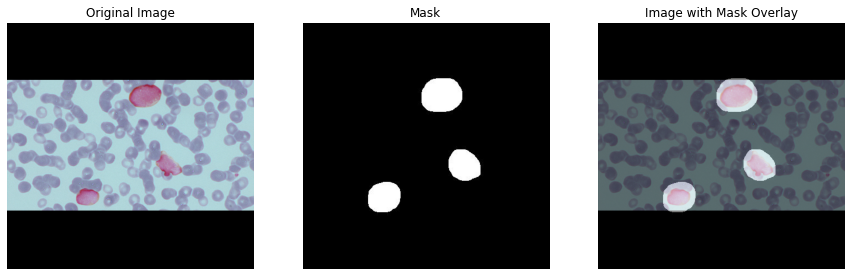

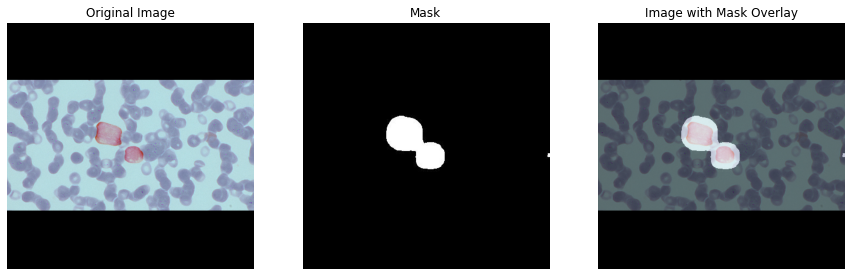

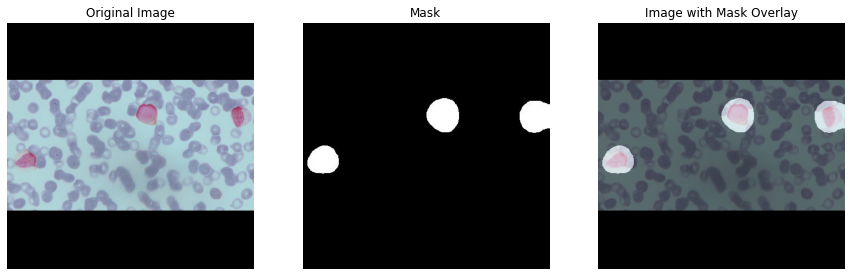

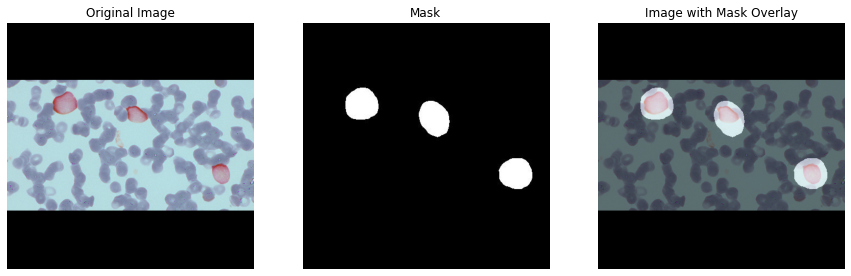

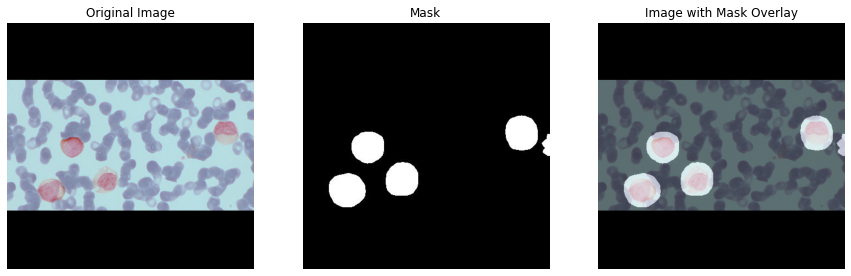

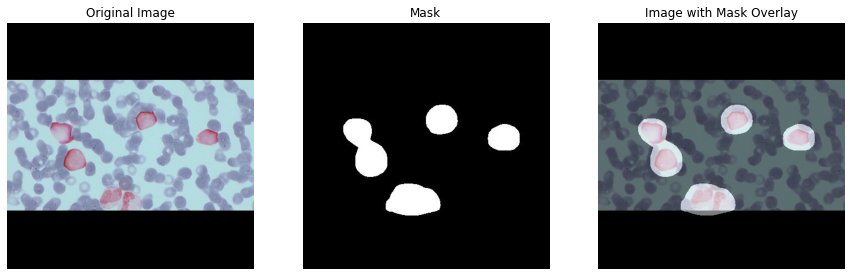

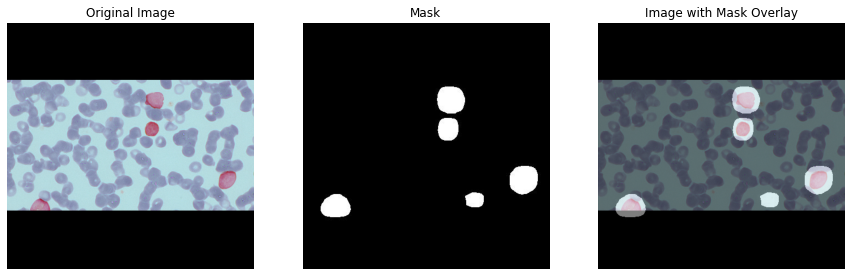

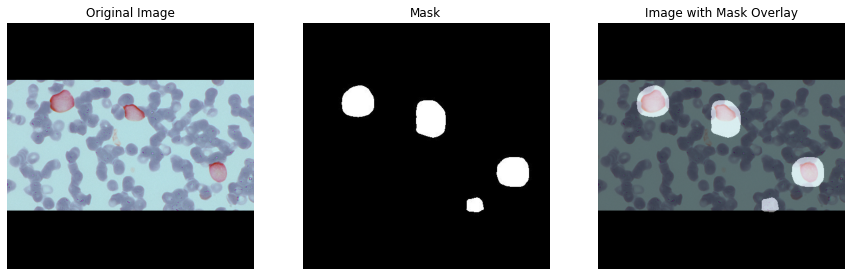

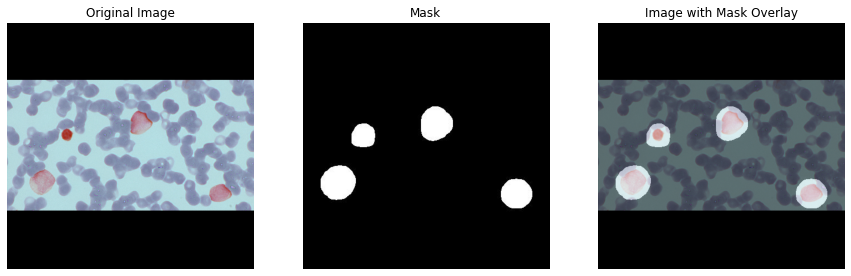

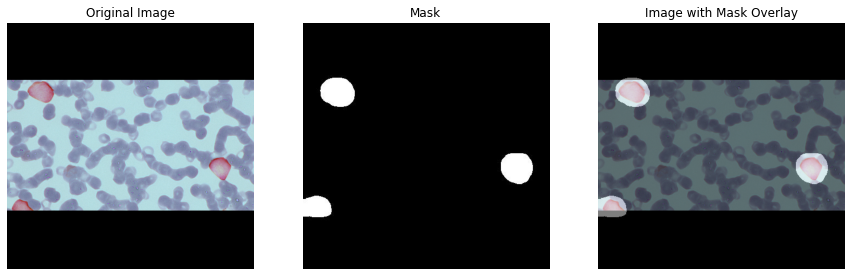

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set the directories for images and masks
image_dir = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA&MASKS/train/ALL'  
mask_dir = '/home/dawlat.akaila/Documents/DL_LABS/PROJECT/DATA&MASKS/train_masks/ALL'   

# List of images and masks
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif','.tiff'))])  # Adjust the extension if needed
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg', '.jpeg', '.tif','.tiff'))])   # Adjust the extension if needed

# Function to plot an image, its mask, and the overlay
def plot_image_and_mask(image_path, mask_path):
    # Define the transformation: resize and pad to maintain aspect ratio
    transform = Compose([
        LongestMaxSize(max_size=448),
        PadIfNeeded(min_height=448, min_width=448, border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0]),
        # Resize(448, 448)
    ])

    # Load image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path)

    augmented = transform(image=image)
    image_resized = augmented['image']
    
    # Create a figure to host the subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot image
    axes[0].imshow(image_resized)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Plot mask
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Plot image with mask overlay
    axes[2].imshow(image_resized)
    axes[2].imshow(mask, cmap='jet', alpha=0.5)  # Adjust alpha for transparency
    axes[2].set_title('Image with Mask Overlay')
    axes[2].axis('off')

    plt.show()

# Assume filenames without extensions are the same
for image_file, mask_file in list(zip(image_files, mask_files))[:10]:
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)

    # Plot for each pair
    plot_image_and_mask(image_path, mask_path)
